In [ ]:
#Author: Rene Lisasi
#Deep Learning 
#Assignment 4
#RNN

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

# Question (a)

In 'AMZN.csv,' daily stock opening, high, low, close, adjusted close, and trading volume are included. For this assignment, only the 'Close' column is used as the feature to predict the stock price. The data is divided into a training set, containing stock prices before January 1st, 2015, and a testing set, containing prices after that date. Implement a function to read the CSV data and split it into the training and testing setsm

In [ ]:
data = pd.read_csv('AMZN.csv')
data = data[['Date', 'Close']]
data.head(3)

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417


In [ ]:
time = data.iloc[:,0].str.replace("-","")
data.iloc[:,0]=time.astype(float)
data.iloc[0,0]

19970515.0

In [ ]:
def split_data(data,split_point):
    start=np.where(data.iloc[:,0]<split_point)
    end=np.where(data.iloc[:,0]>=split_point)

    training_data=(data.iloc[start])
    testing_data=(data.iloc[end])

    #Split data
    return training_data, testing_data

training_data,testing_data=split_data(data,20150101)
training_data

,Date,Close
0,19970515.0,0.097917
1,19970516.0,0.086458
2,19970519.0,0.085417
3,19970520.0,0.081771
4,19970521.0,0.071354
...,...,...
4432,20141224.0,15.151500
4433,20141226.0,15.454500
4434,20141229.0,15.602000
4435,20141230.0,15.515000


# Question (b)
Utilizing only the 'Close' column is inadequate for predicting future stock prices. Create new features by 'shifting' the current day's stock price and the previous T days' stock prices, generating new feature columns (where T ∈ [3, 10]). For instance, if T = 3, each sample will have the close prices at T-3, T-2, T-1, and T time points as features. Additionally, the stock price at T+1 time point will be used as the label.

In [ ]:
def feature_engeering(data_df,timestep):
    data_df2=data_df.copy()
    if len(data_df2)>=timesteps:
        for step in range(timestep):
            data_df2[f'T-{timesteps-step-1}']=data_df2['Close'].shift(step)
        data_df2['T+1']=data_df2['Close'].shift(-2)
        data_df2=data_df2.drop('Close',axis=1)
        data_df2=data_df2.drop('Date',axis=1)
        data_df2=data_df2.dropna()
        data_df2=data_df2.iloc[:,::-1]
        print(data_df2)
        labels=data_df2['T+1'].values
        data_df2=data_df2.drop(['T+1'],axis=1)
        features=data_df2.values
        return features,labels

timesteps=5
X_train,y_train = feature_engeering(training_data,timesteps)
X_test,y_test = feature_engeering(testing_data,timesteps)


print(X_train[0])
print(y_train[0])

            T+1        T-0        T-1        T-2        T-3        T-4
4      0.075000   0.097917   0.086458   0.085417   0.081771   0.071354
5      0.079167   0.086458   0.085417   0.081771   0.071354   0.069792
6      0.076563   0.085417   0.081771   0.071354   0.069792   0.075000
7      0.075260   0.081771   0.071354   0.069792   0.075000   0.079167
8      0.075000   0.071354   0.069792   0.075000   0.079167   0.076563
...         ...        ...        ...        ...        ...        ...
4430  15.151500  14.753000  14.944000  14.886500  14.995000  15.327000
4431  15.454500  14.944000  14.886500  14.995000  15.327000  15.314500
4432  15.602000  14.886500  14.995000  15.327000  15.314500  15.151500
4433  15.515000  14.995000  15.327000  15.314500  15.151500  15.454500
4434  15.517500  15.327000  15.314500  15.151500  15.454500  15.602000

[4431 rows x 6 columns]
             T+1        T-0         T-1         T-2         T-3         T-4
4441   14.570500  15.426000   15.109500   14.76

In [ ]:
#reshaping to match the rnn/lstm shape requirement
X_train=np.expand_dims(X_train,axis=2)
y_train=np.expand_dims(y_train,axis=1)
X_test=np.expand_dims(X_test,axis=2)
y_test=np.expand_dims(y_test,axis=1)
#remove last rows from features to match label shape
X_train=np.delete(X_train,[-1],axis=0)
X_test=np.delete(X_test,[-1],axis=0)
#print(X_train)
print('y',y_train)
print(X_test.shape)
print(y_test.shape)

y [[ 0.075   ]
 [ 0.079167]
 [ 0.076563]
 ...
 [15.602   ]
 [15.515   ]
 [15.5175  ]]
(2072, 5, 1)
(2073, 1)


In [ ]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]


train_dataset = TimeSeriesDataset(torch.tensor(X_train).float(), y_train)
test_dataset = TimeSeriesDataset(torch.tensor(X_test).float(), y_test)
train_dataset.__getitem__(-1)
#y_test.iloc[-1]

(tensor([[14.9950],
         [15.3270],
         [15.3145],
         [15.1515],
         [15.4545]]),
 array([15.5175]))

# Question (c)
Construct a stacked RNN model for stock price prediction. Train the model using mean squared error as the objective function. Define the number of hidden layers and RNN layers in your implementation.

In [ ]:
#batching and dataloading
from torch.utils.data import DataLoader

batch_size=32

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

# Checking the dataset
for features, labels in test_loader:
    print('Stock batch dimensions:', features.shape)
    print('Stock label dimensions:', labels.shape)
    break

Stock batch dimensions: torch.Size([32, 5, 1])
Stock label dimensions: torch.Size([32, 1])


In [ ]:
class RNN_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN_model,self).__init__()
        #others
        self.batch_norm=torch.nn.BatchNorm1d(num_features=timesteps)
        #model
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.rnn=torch.nn.RNN(input_size=input_size,hidden_size=hidden_size,num_layers=num_layers,nonlinearity='relu')
        self.fc = nn.Linear(hidden_size, num_layers)
        # self.tanh=torch.nn.Tanh()

    def forward(self, x):
        #x=self.batch_norm(x)
        hx=torch.zeros(self.num_layers,x.size(1),self.hidden_size)
        #print(x.type())
        x,hx=self.rnn(x,hx)
        #print(x.type(),hx.type())
        x=x[:,-1,:]
        #print(x.type())
        x=self.fc(x)
        #print(x.type())
        # x=self.tanh(x)
        return x

    # Initialize the RNN.

# input size : (batch, seq_len, input_size)
# out shape = (batch, seq_len, num_directions * hidden_size)
# h_n shape  = (num_layers * num_directions, batch, hidden_size)

model = RNN_model(1,timesteps,2)
model

RNN_model(
  (batch_norm): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rnn): RNN(1, 5, num_layers=2)
  (fc): Linear(in_features=5, out_features=2, bias=True)
)

In [ ]:
torch.manual_seed(1)
learning_rate = 0.1

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(sample_model.parameters(), lr=1e-3, weight_decay=1e-5)

def train_one_epoch():
    training_cost=[]
    for batch_idx, (features, targets) in enumerate(train_loader):
        #features.unsqueeze(2)
        features=features.to(dtype=torch.float32)
        targets=targets.to(dtype=torch.float32)
        #print(features.shape,targets.shape)
        output=model(features)
        cost=loss_function(output, targets)
        cost=cost.to(dtype=torch.float32)
        #print(cost.dtype)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        #print(cost)
    training_cost.append(cost.item())
    return training_cost

def test_one_epoch():
    test_loss=[]
    predicted=[]
    targets=[]
    for batch_idx,(data, target) in enumerate(test_loader):
        data=data.to(dtype=torch.float32)
        target=target.to(dtype=torch.float32)
        output= model(data)
        loss = loss_function(output, target)
        test_loss.append(loss.item())
        #print('pred',output)
        #print('targ',target)

        targets.append(target)
        predicted.append(output)
    return test_loss, predicted,targets

sample_loss=train_one_epoch()
sample_loss

[0.15678773820400238]

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    sample_loss=train_one_epoch()
sample_loss

[0.05522087588906288]

In [ ]:
_,predicted_rnn,targs=test_one_epoch()
predicted_rnn=torch.cat(predicted_rnn,dim=0)
predicted_rnn=predicted_rnn.detach()
targs=torch.cat(targs,dim=0)
print(targs[100])
print(predicted_rnn[100])

tensor([21.3475])
tensor([21.9640, 21.9639])


/opt/homebrew/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([24, 1])) that is different to the input size (torch.Size([24, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
print(len(predicted_rnn))
print(len(targs))

2072
2072


# Question (e)
Evaluate the prediction results using mean squared error and depict the approximation curve, showcasing predicted stocks alongside actual stocks on the testing set

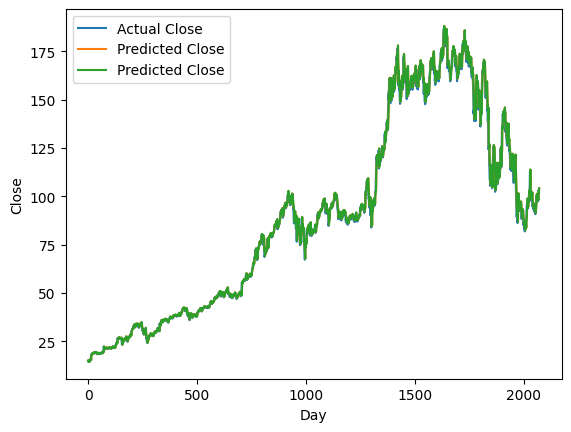

In [ ]:
plt.plot(targs, label='Actual Close')
plt.plot(predicted_rnn, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


# Question (f)
Develop a stacked LSTM model for stock prediction. Train the model using mean squared error as the objective function. Define the number of hidden layers and LSTM layers in your implementation. Visualize the predicted stocks using LSTM and RNN in a single figure and provide an explanation of which model performs better and why.

In [ ]:
class LSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size,output_size, num_layers):
        super(LSTM_model,self).__init__()
        #others
        s#elf.batch_norm=torch.nn.BatchNorm1d(num_features=timesteps)
        #self.batch_norm1=torch.nn.BatchNorm1d(num_features=50)
        #model
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.output_size=output_size
        self.num_layers=num_layers
        self.LSTM=torch.nn.LSTM(input_size=input_size,hidden_size=hidden_size,num_layers=num_layers)
        # self.LSTM1=torch.nn.LSTM(input_size=hidden_size,hidden_size=hidden_size,num_layers=num_layers)
        self.fc = torch.nn.Linear(hidden_size, output_size)
        self.relu=torch.nn.ReLU()

    def forward(self, x):
        #x=self.batch_norm(x)
        hx=torch.zeros(self.num_layers,x.size(1),self.hidden_size)
        cx=torch.zeros(self.num_layers,x.size(1),self.hidden_size)
        #print(x.type())

        x,(hx,cx)=self.LSTM(x)
        # x,(hx,cx)=self.LSTM1(x,(hx,cx))
        x=x[:,-1,:]
        #print(x.shape)
        x=self.fc(x)
        x=self.relu(x)

        #print(x.type())
        # x=self.tanh(x)
        return x

model = LSTM_model(1,50,1,2)
model

LSTM_model(
  (batch_norm): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LSTM): LSTM(1, 50, num_layers=2)
  (fc): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
torch.manual_seed(1)
learning_rate = 0.01

loss_function_lstm = nn.MSELoss()
optimizer_lstm = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train_one_epoch_lstm():
    training_cost=[]
    for batch_idx, (features, targets) in enumerate(train_loader):
        #features.unsqueeze(2)
        optimizer_lstm.zero_grad()
        features=features.to(dtype=torch.float32)
        targets=targets.to(dtype=torch.float32)
        #print(features.shape,targets.shape)
        output=model(features)
        cost=loss_function_lstm(output, targets)
        cost=cost.to(dtype=torch.float32)
        #print(cost.dtype)
        cost.backward()
        optimizer_lstm.step()
        #print(cost)
    training_cost.append(cost.item())
    return training_cost

def test_one_epoch_lstm():
    test_loss=[]
    predicted=[]
    targets=[]
    for batch_idx,(data, target) in enumerate(test_loader):
        data=data.to(dtype=torch.float32)
        target=target.to(dtype=torch.float32)
        output = model(data)
        loss = loss_function(output, target)
        test_loss.append(loss.item())
        targets.append(target)
        predicted.append(output)
    return test_loss, predicted,targets

sample_loss=train_one_epoch_lstm()
sample_loss

[0.37567076086997986]

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    sample_loss=train_one_epoch_lstm()
sample_loss

[0.01032504253089428]

In [ ]:
_,predicted_lstm,targs=test_one_epoch_lstm()
predicted_lstm=torch.cat(predicted_lstm,dim=0)
predicted_lstm=predicted_lstm.detach()
targs=torch.cat(targs,dim=0)
print(len(targs))
print(len(predicted_lstm))


2072
2072


In [ ]:
print(predicted_lstm[0])
print(len(targs))

tensor([15.3906])
2072


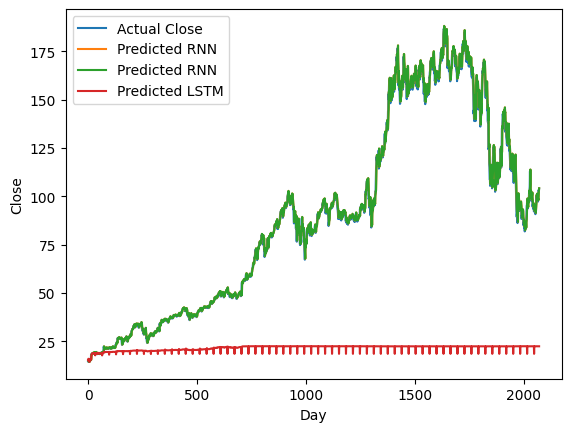

In [ ]:
# PLOT
plt.plot(targs, label='Actual Close')
plt.plot(predicted_rnn, label='Predicted RNN')
plt.plot(predicted_lstm, label='Predicted LSTM')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
